In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import plot_model

In [ ]:
def RMSE(y_test,y_pred):
    y_test = list(y_test.values); y_test = [float(e) for e in y_test]
    y_pred = list(y_pred.values); y_pred = [float(e) for e in y_pred]
    n = len(y_test)
    rmse_list = [float(y_test[i]-y_pred[i])*float(y_test[i]-y_pred[i]) for i in range(n)]
    return np.sqrt(sum(rmse_list)/float(n))

#Load and Reshape Data

In [ ]:
DATA_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Data/Load"

In [ ]:
data = []
#for y in range(2017,2023):
for y in [2022]:
  df = pd.read_csv(f"{DATA_DIR}/Load_{y}.csv")
  data.append(df)
data = pd.concat(data)
print(data.head(20).to_string())
NYC = data['N.Y.C.']; 
print(NYC.mean())
print(NYC.std())
n = len(NYC.index)
t = int(7*24*(60/5))
#NYC_train = NYC.iloc[0:n-t]
#NYC_valid = NYC.iloc[n-t:]


             Time Stamp     CAPITL     CENTRL    DUNWOD    GENESE    HUD VL     LONGIL    MHK VL    MILLWD     N.Y.C.     NORTH       WEST        NYCA
0   01/01/2022 00:00:00  1183.7480  1573.4424  553.1212  951.8785  941.1690  1928.9694  737.3262  258.1784  4670.6790  663.5603  1459.3739  14921.4463
1   01/01/2022 00:05:00  1180.9607  1571.3107  559.5914  950.8312  938.3668  1917.0785  724.0930  259.7224  4623.9080  676.8036  1456.2012  14858.8675
2   01/01/2022 00:10:00  1159.3552  1551.6155  519.5945  943.3434  928.1785  1898.9941  725.9697  251.4069  4642.4116  668.1530  1452.4133  14741.4357
3   01/01/2022 00:15:00  1168.7172  1568.2451  528.3297  941.5784  946.6538  1905.9005  721.0952  245.3264  4606.2410  665.7786  1439.7062  14737.5721
4   01/01/2022 00:20:00  1163.8214  1563.8730  549.2172  933.8751  912.4292  1884.5797  720.9675  248.5621  4589.0850  657.4609  1429.9586  14653.8297
5   01/01/2022 00:25:00  1153.7329  1512.7001  545.8400  931.5654  921.0825  1872.7023  713.09

In [ ]:
m = 5687.832418083788
std = 1185.1401264331366
def transform_dataset(dataset,mi=m,stdi=std):
  return (dataset-mi)/stdi
def untransform_dataset(dataset,mi=m,stdi=std):
  return (dataset*stdi)+mi

def create_dataset(dataset, hist_window=18,forecast_window=18):
  #Lookback of 18 includes 90 minutes of previous data
  dataX, dataY = [], []
  for i in range(len(dataset)-hist_window-forecast_window):
    #a = dataset[i:(i+look_back), 0].reshape(-1)
    a = dataset[i:(i+hist_window)].reshape(-1)
    dataX.append(a)
    #dataY.append(dataset[i + look_back, 0])
    dataY.append(dataset[i + hist_window:  i + hist_window+forecast_window])
  return np.array(dataX), np.array(dataY)

x,y = create_dataset(NYC.values,18,1)
train,label_t = x[0:n-t],y[0:n-t]
valid,label_v = x[n-t:], y[n-t:]
print(NYC.head(38));print(train[0]);print(label_t[0])

0     4670.6790
1     4623.9080
2     4642.4116
3     4606.2410
4     4589.0850
5     4574.2725
6     4573.3516
7     4510.8810
8     4510.0913
9     4499.7580
10    4513.1025
11    4497.5947
12    4533.3545
13    4437.2720
14    4402.0660
15    4411.3687
16    4357.5664
17    4374.4230
18    4332.5957
19    4330.9960
20    4325.8213
21    4314.4316
22    4297.0850
23    4305.0767
24    4263.1147
25    4252.3690
26    4254.9824
27    4251.5150
28    4193.1797
29    4231.3090
30    4211.2900
31    4193.6570
32    4182.4470
33    4173.1610
34    4150.7040
35    4151.2812
36    4143.7563
37    4141.9680
Name: N.Y.C., dtype: float64
[4670.679  4623.908  4642.4116 4606.241  4589.085  4574.2725 4573.3516
 4510.881  4510.0913 4499.758  4513.1025 4497.5947 4533.3545 4437.272
 4402.066  4411.3687 4357.5664 4374.423 ]
[4332.5957]


In [ ]:
# reshape input to be [samples, time steps, features]
train = np.reshape(train, (train.shape[0], 1, train.shape[1]))
#x_train = x_train.reshape(-1, 28, 28, 1)
print(train.shape)
valid = np.reshape(valid, (valid.shape[0], 1, valid.shape[1]))

(106020, 1, 18)


#Build Model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 4)                 368       
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 373
Trainable params: 373
Non-trainable params: 0
_________________________________________________________________


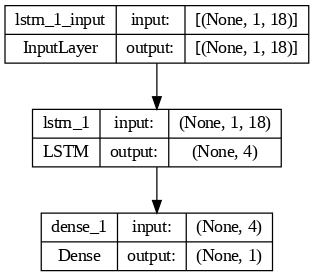

In [ ]:
import datetime
tag_i='test'
MODEL_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Model/Test"
model_name = 'test_model.h5'

hist_window=18;forecast_window=18

def create_LSTM_model(LSTM_i = 4, dropout=0.3,
                      learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooled Output for classification purposes.
    """
    model = Sequential()
    model.add(LSTM(LSTM_i, input_shape=(1, hist_window)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_LSTM_model()
model.summary()
plot_model(model, show_shapes=True, dpi=90)

In [ ]:
#Fit Model
print(datetime.datetime.now())
#model.fit(train, label_t, epochs=100, batch_size=1, verbose=2)
train_xfr = transform_dataset(train)
label_t_xfr = transform_dataset(label_t)
model.fit(train_xfr, label_t_xfr, epochs=5, batch_size=1, verbose=2)
model.save(f"{MODEL_DIR}/{model_name}",save_format='h5')

#model = create_LSTM_model()
#model.load_weights(f"{MODEL_DIR}/{model_name}") 

2023-02-01 17:29:06.749969
Epoch 1/5
106020/106020 - 235s - loss: 0.0059 - 235s/epoch - 2ms/step
Epoch 2/5
106020/106020 - 231s - loss: 0.0012 - 231s/epoch - 2ms/step
Epoch 3/5
106020/106020 - 231s - loss: 0.0010 - 231s/epoch - 2ms/step
Epoch 4/5
106020/106020 - 230s - loss: 9.9099e-04 - 230s/epoch - 2ms/step
Epoch 5/5
106020/106020 - 230s - loss: 9.7180e-04 - 230s/epoch - 2ms/step


63/63 [==============================] - 0s 2ms/step
Test Score: 21.46 RMSE


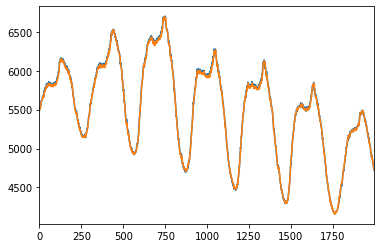

In [ ]:
# make predictions
valid_xfr = transform_dataset(valid)
testPredict = model.predict(valid_xfr)
testPredict = untransform_dataset(testPredict)
testPredict = pd.DataFrame(testPredict)
testY = pd.DataFrame(label_v)

## invert predictions
#testPredict = anti_transform(testPredict)   #scaler.inverse_transform(testPredict)
#testY = anti_transform(testY)               #scaler.inverse_transform([testY])

# calculate root mean squared error
print('Test Score: %.2f RMSE' % (RMSE(testY, testPredict)))

# shift test predictions for plotting
plt.plot(testY)
plt.plot(testPredict)
n = len(testPredict)
plt.xlim([0,n])
plt.show()
#plt.savefig(tag_i+".jpeg")
#plt.clf(); plt.close()


In [ ]:
# 5 minutes